In [1]:
# adapted from Bin Xia's (@Xsmos) Mosaic evaluation code

import gc
import sys
from datetime import datetime as dt
from pathlib import Path
from time import time

import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
import umap
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D
from tqdm import tqdm
from transformers import AutoModel, AutoConfig

from multi_io_dataset import MultiIODataset, MultiIOCollator

In [2]:
# Repository ID on Hugging Face Hub
REPO_ID = "StarNetLaboratory/mosaic"

# Since custom modeling code (foundation_bert.py) is used, 
# trust_remote_code must be set to True.
TRUST_CODE = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
gc.collect()

0

In [3]:
print(f"--- 1. Attempting to load configuration ---")
try:
    # Attempt to load config to verify config.json is present and readable
    config = AutoConfig.from_pretrained(REPO_ID, trust_remote_code=TRUST_CODE)
    print(f"✅ Config loaded successfully: {config.architectures}")
except Exception as e:
    print(f"❌ Config loading failed: {e}")
    sys.exit(1)

--- 1. Attempting to load configuration ---
✅ Config loaded successfully: ['FoundationBert']


In [4]:
print(f"\n--- 2. Attempting to load model ---")
try:
    # Detect device (GPU if available, else CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # This call triggers transformers to download and execute foundation_bert.py
    # and load weights from model.safetensors
    model = AutoModel.from_pretrained(
        REPO_ID, 
        config=config, 
        trust_remote_code=TRUST_CODE, 
        torch_dtype=torch.float32 # Match the dtype used during training/local testing
    ).to(device)
    
    model.eval()
    
    # Calculate and print total parameters to verify the architecture
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model loaded successfully on {device}")
    print(f"Model modalities: {model.modalities}")
    print(f"⛳️ Total parameters: {total_params:,}")

except Exception as e:
    print(f"❌ Model loading failed.")
    print(f"Check file integrity and remote code logic (foundation_bert.py).")
    print(f"Error details: {e}")
    sys.exit(1)


--- 2. Attempting to load model ---


`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded successfully on cpu
Model modalities: ['SFH', 'SED', 'mag_{band}_lsst', 'mag_{band}_spherex', 'redshift', 'halo_mass', 'stellar_mass']
⛳️ Total parameters: 135,959,813


In [5]:
# download full dataset here: 
model.dataset_path = './data/supermockCut.json' 


In [6]:
print(f"🚀 loading dataset 🚀")
dataset = MultiIODataset(
    data_path=model.dataset_path,
    tokenizer=None,
    masking_prob=0, # don't mask anything on dataset load
    input_std=0, # no noise in input
    norm_file="./data/data_normalization.json", 
    split='val',
    modalities=model.modalities,
    training=False,
)

collator = MultiIOCollator(tokenizer=None)

🚀 loading dataset 🚀
⚠️ self.training=False, self.modalities=['SFH', 'SED', 'mag_{band}_lsst', 'mag_{band}_spherex', 'redshift', 'halo_mass', 'stellar_mass'], masking_prob=0
🚀 Loading data from ./data/supermockCut.json 🚀
✅ ./data/supermockCut.json loaded in 0.03 seconds ✅
{'SED': ['SED_1005.00', 'SED_1015.00', 'SED_1025.00', 'SED_1035.00', 'SED_1045.00', 'SED_1055.00', 'SED_1065.00', 'SED_1075.00', 'SED_1085.00', 'SED_1095.00', 'SED_1105.00', 'SED_1115.00', 'SED_1125.00', 'SED_1135.00', 'SED_1145.00', 'SED_1155.00', 'SED_1165.00', 'SED_1175.00', 'SED_1185.00', 'SED_1195.00', 'SED_1205.00', 'SED_1215.00', 'SED_1225.00', 'SED_1235.00', 'SED_1245.00', 'SED_1255.00', 'SED_1265.00', 'SED_1275.00', 'SED_1285.00', 'SED_1295.00', 'SED_1305.00', 'SED_1315.00', 'SED_1325.00', 'SED_1335.00', 'SED_1345.00', 'SED_1355.00', 'SED_1365.00', 'SED_1375.00', 'SED_1385.00', 'SED_1395.00', 'SED_1405.00', 'SED_1415.00', 'SED_1425.00', 'SED_1435.00', 'SED_1442.00', 'SED_1447.00', 'SED_1455.00', 'SED_1465.00',

## Masking guidelines

Note: feature list goes in fixed order: ['SFH', 'SED', 'mag {band} {lsst}', 'mag {band} spherex', 'redshift', 'halo_mass', 'stellar_mass']

* SFH: (startMask, endMask) in lookback time [Gyr]
    - data spans from ~0.199 - 13.798

* SED: (startMask, endMask) in observed-frame wavelength ($\AA$) (generally redshifted wavelengths in data span ~3k-130k $\AA$)

* LSST mags: (startIdx, endIdx) inclusive of bands ['u','g','r','i','z','Y']. If you list `0` as your endIdx, it it noninclusive through the end of the array. E.g. `(3, 0)` would mask `z, Y` while `(3, 5)` would mask `i, z, Y`. 

* Spherex mags: (startBand, endBand) for mask. Data divided into 102 bands. 

* redshift: 0 (don't mask) or 1 (mask)

* halo_mass: 0 (don't mask) or 1 (mask)

* stellar_mass: 0 (don't mask) or 1 (mask)

Generally, for the end indices if you use any value higher than the length of the array or higher than 1, it is interpreted as 1 (scalar) or "through the end of the array" (vector)

batch.keys()=dict_keys(['input', 'labels'])
batch['input'].keys()=dict_keys(['SFH', 'SED', 'mag_{band}_lsst', 'mag_{band}_spherex', 'scalars'])
outputs.keys()=dict_keys(['SFH_logits', 'SED_logits', 'mag_{band}_lsst_logits', 'mag_{band}_spherex_logits', 'scalars_logits'])


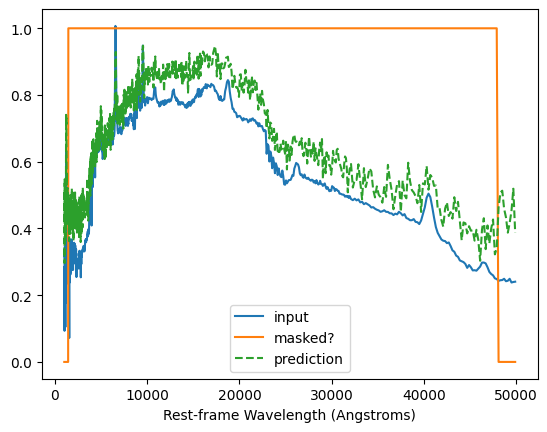

In [7]:
# sample masking probabilities for each modality (they can be combined)

# SED EXAMPLE
dataset.masking_prob = (0, (3000, 100000), 0,0,0,0,0) # masks SEDs from 3k - 100k observed-frame Angstroms (observer frame)
batch = next(iter(dataset)) # take one sample

print(f"{batch.keys()=}")
print(f"{batch['input'].keys()=}")

plt.plot(dataset.SED_wavelength, batch['input']['SED'],  label='input')
plt.plot(dataset.SED_wavelength, batch['labels']['SED'],  label='masked?')

batch = collator([batch]) # preprocessing
batch = {k: v.to(model.device) for k, v in batch.items()} # move to GPU

with torch.no_grad():
    outputs, input_label_mapping = model(batch, return_input_label_mapping=True) # prediction
    
print(f"{outputs.keys()=}")

predicted = outputs['SED_logits'].squeeze([0,-1]).cpu().numpy() # reshape
plt.plot(dataset.SED_wavelength, predicted, label='prediction', linestyle='--')
plt.xlabel('Rest-frame Wavelength (Angstroms)')
plt.legend()
plt.show()


batch.keys()=dict_keys(['input', 'labels'])
batch['input'].keys()=dict_keys(['SFH', 'SED', 'mag_{band}_lsst', 'mag_{band}_spherex', 'scalars'])
outputs.keys()=dict_keys(['SFH_logits', 'SED_logits', 'mag_{band}_lsst_logits', 'mag_{band}_spherex_logits', 'scalars_logits'])


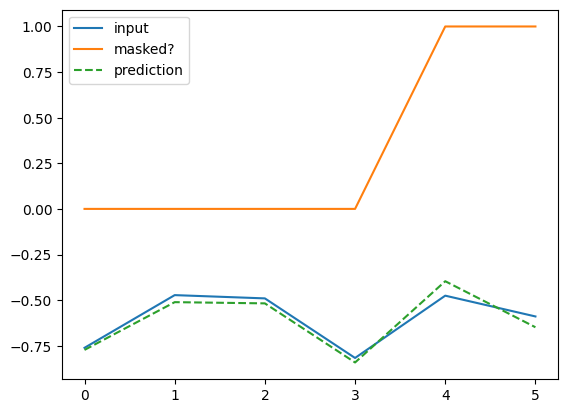

In [8]:
# MAGNITUDE EXAMPLE
dataset.masking_prob=(1,1,(3, 0),1,0,1,1) # masking LSST mags z and Y
batch = next(iter(dataset)) # take one sample

print(f"{batch.keys()=}")
print(f"{batch['input'].keys()=}")

plt.plot(batch['input']['mag_{band}_lsst'], label='input')
plt.plot(batch['labels']['mag_{band}_lsst'], label='masked?')

batch = collator([batch]) # preprocessing
batch = {k: v.to(model.device) for k, v in batch.items()} # move to GPU

with torch.no_grad():
    outputs, input_label_mapping = model(batch, return_input_label_mapping=True) # prediction
    
print(f"{outputs.keys()=}")

# predicted = outputs['mag_{band}_lsst_logits'][:,1].squeeze([0,-1]).cpu().numpy() # reshape
predicted = outputs['mag_{band}_lsst_logits'].squeeze([0,-1]).cpu().numpy() # reshape
plt.plot(predicted, label='prediction', linestyle='--')
plt.legend()
plt.show()

In [9]:
for i, band in enumerate(['u', 'g', 'r', 'i', 'z', 'Y']):
    print(f"{band}:")
    print(f'pred val: {dataset.unscale_data(outputs['mag_{band}_lsst_logits'][:,i].item(), f'mag_{band}_lsst')}')
    print(f'true val: {dataset.unscale_data(batch['input_mag_{band}_lsst'][:,i].item(), f'mag_{band}_lsst')}')

u:
pred val: 20.002004376333907
true val: 20.02996131784173
g:
pred val: 20.63898239053407
true val: 20.732802107920406
r:
pred val: 20.622688883083946
true val: 20.68916774515732
i:
pred val: 19.834338577823665
true val: 19.894455566774656
z:
pred val: 20.918207432573308
true val: 20.725517990891916
Y:
pred val: 20.30442104628687
true val: 20.448281088589567


batch.keys()=dict_keys(['input', 'labels'])
batch['input'].keys()=dict_keys(['SFH', 'SED', 'mag_{band}_lsst', 'mag_{band}_spherex', 'scalars'])
outputs.keys()=dict_keys(['SFH_logits', 'SED_logits', 'mag_{band}_lsst_logits', 'mag_{band}_spherex_logits', 'scalars_logits'])


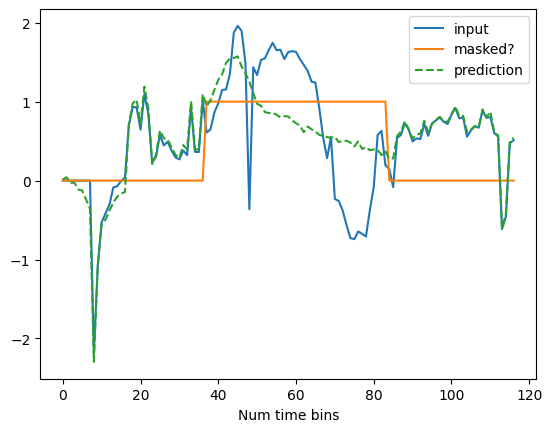

In [10]:
# SFH EXAMPLE 
dataset.masking_prob=((3,10),0,0,0,0,0,0) # masking from 3-10 Gyr loockback time
batch = next(iter(dataset)) # take one sample

print(f"{batch.keys()=}")
print(f"{batch['input'].keys()=}")

plt.plot(batch['input']['SFH'], label='input')
plt.plot(batch['labels']['SFH'], label='masked?')

batch = collator([batch]) # preprocessing
batch = {k: v.to(model.device) for k, v in batch.items()} # move to GPU

with torch.no_grad():
    outputs, input_label_mapping = model(batch, return_input_label_mapping=True) # prediction
    
print(f"{outputs.keys()=}")

predicted = outputs['SFH_logits'].squeeze([0,-1]).cpu().numpy() # reshape
plt.plot(predicted, label='prediction', linestyle='--')
plt.xlabel('Num time bins')
plt.legend()
plt.show()

In [11]:
# stellar mass example:

dataset.masking_prob=(0,0,0,0,0,0,1) # masking stellar mass
batch = next(iter(dataset)) # take one sample

print(f"{batch.keys()=}")
print(f"{batch['input'].keys()=}")

batch = collator([batch]) # preprocessing
batch = {k: v.to(model.device) for k, v in batch.items()} # move to GPU

with torch.no_grad():
    outputs, input_label_mapping = model(batch, return_input_label_mapping=True) # prediction

print(f"{outputs.keys()=}")

print(f'pred val: {dataset.unscale_data(outputs['scalars_logits'][:,1].item(), 'stellar_mass')}')
print(f'true val: {dataset.unscale_data(batch['input_scalars'][:,1].item(), 'stellar_mass')}')
# log10 Msol/h

batch.keys()=dict_keys(['input', 'labels'])
batch['input'].keys()=dict_keys(['SFH', 'SED', 'mag_{band}_lsst', 'mag_{band}_spherex', 'scalars'])
outputs.keys()=dict_keys(['SFH_logits', 'SED_logits', 'mag_{band}_lsst_logits', 'mag_{band}_spherex_logits', 'scalars_logits'])
pred val: 10.446969985961914
true val: 10.409051895141602


## Umaps and combining mask combos

In [12]:
def save_umap(umap_dir, record4u):
    with h5py.File(umap_dir, 'r+') as f:
        print(f"⚠️ before: {f.keys()=}; {[f[k].shape for k in f.keys()]}")
        for k, v in record4u.items():
            record4u[k] = torch.stack(v, dim=0)
            if k in scalar_keys:
                record4u[k] = record4u[k][:, scalar_keys.index(k)]
                record4u[k] = record4u[k].view(-1,1)
            print(f"{k=}; {record4u[k].shape=}; {len(v)=}; {v[0].shape=}")
            f.create_dataset(k, data=record4u[k], maxshape=(None, record4u[k].shape[-1]), chunks=True)
        
        print(f"⚠️ after: {f.keys()=}; {[f[k].shape for k in f.keys()]}")

In [13]:
def predict():
    record4u = {k: [] for k in ['mag_{band}_lsst', 'redshift', 'halo_mass', 'stellar_mass']}
    modalities = model.modalities
    loopover = 'masking_prob'
    true_table = {k: [[] for _ in range(len(combinations))] for k in modalities}
    predicted_table = {k: [[] for _ in range(len(combinations))] for k in modalities}
    mask_idx_table = {k: [[] for _ in range(len(combinations))] for k in modalities}
    error_vec = {k: [[] for _ in range(len(combinations))] for k in vector_keys}
    unscaled_scalars = {comb: [] for comb in combinations}
    num = [0] * len(combinations)
    print(f"🌟 {modalities=}; {len(combinations)=}; {umap_dir=}; {record4u=}")

    for row, comb in enumerate(combinations):
        setattr(dataset, loopover, comb)
        for i, batch in enumerate(tqdm(dataset, desc=f"{row=}/{len(combinations)}, {comb=}")):
            batch = collator([batch])
            batch = {k: v.to(model.device) for k, v in batch.items()}
            with torch.no_grad():
                outputs, input_label_mapping = model(batch, return_input_label_mapping=True)

            for col, tgt_modality in enumerate(modalities):
                data = input_label_mapping.get(tgt_modality, input_label_mapping['scalars'])
                mask_idx = torch.where(data['labels'].squeeze(0) == True)[0].cpu()
                mask_idx_table[tgt_modality][row].append(mask_idx)

                true_num = data['input'].squeeze(0).cpu()
                
                if tgt_modality in record4u:
                    record4u[tgt_modality].append(true_num)

                predicted_num = outputs.get(f"{tgt_modality}_logits", outputs['scalars_logits'])
                predicted_num = predicted_num.squeeze([0,-1]).cpu()

                # unscale_data
                if tgt_modality in vector_keys:
                    true_table[tgt_modality][row].append(torch.tensor([dataset.unscale_data(d, dataset.vector_bin_labels[tgt_modality][i]) for i, d in enumerate(true_num)]))
                    predicted_table[tgt_modality][row].append(torch.tensor([dataset.unscale_data(d, dataset.vector_bin_labels[tgt_modality][i]) for i, d in enumerate(predicted_num)]))
                    error_vec[tgt_modality][row].append(predicted_num-true_num)
                else:
                    true_table[tgt_modality][row].append(torch.tensor(dataset.unscale_data(true_num[col-len(vector_keys)], tgt_modality)))
                    predicted_table[tgt_modality][row].append(torch.tensor(dataset.unscale_data(predicted_num[col-len(vector_keys)], tgt_modality)))
                    unscaled_scalars[comb].append(torch.stack([true_num[col-len(vector_keys)], predicted_num[col-len(vector_keys)]]))

            num[row] += 1
            if num[row] >= num_umap:
                break
    
    unscaled_scalars = {comb: torch.stack(v) for comb, v in unscaled_scalars.items()}
    
    if hasattr(model, 'save_umap_for'):
        save_umap(umap_dir, record4u)
    print("✅ save_umap completed")
    
    return true_table, predicted_table, unscaled_scalars, error_vec, mask_idx_table

In [14]:
Range = dict(late_time = (0,10),
    UV = (100,3000),
    optical = (3000,8000),
    IR = (8000,1000000)
)

for k, v in list(Range.items()):
    Range[f"non-{k}"] = (v[1], v[0])

inverse_Range = {v: k for k, v in Range.items()}

print(f"{Range};\n {inverse_Range}")


getattr(dataset, "fixed_idx", 'Not Given')

umap_dir = Path(f'./outputs/umap_{dt.now().isoformat(timespec='seconds')}.h5')

if umap_dir.exists():
    if hasattr(model, 'save_umap_for'):
        delattr(model, 'save_umap_for')
        print(f"⚠️ deleted model.save_umap_for to avoid duplicated calculation.")
    else:
        print(f"⚠️ {umap_dir.exists()=} and model.save_umap_for doesn't exist.")
else:
    model.save_umap_for = umap_dir

masking_prob = [
    (1,1,(4,0),1,0,1,1), #mask sfh, sed, Y band LSST mags, spherex mags, halo mass, and stellar mass
    (1,1,1,1,0,1,0), #mask sfh, seds, lsst mags, spherex mags, halo mass
    (1,1,0,1,1,1,0) #mask sfh, seds, spherex mags, redshift, halo mass
]
# ['SFH', 'SED', 'mag_{band}_lsst', 'mag_{band}_spherex', 'redshift', 'halo_mass', 'stellar_mass']
input_std = [
    (0,0,0,0,0,0,0) #no noise
]

vector_keys = dataset.vector_keys
scalar_keys = dataset.scalar_keys


combinations = masking_prob
dataset.input_std = input_std[0]

num_umap = 50
true_table, predicted_table, unscaled_scalars, error_vec, mask_idx_table = predict()

{'late_time': (0, 10), 'UV': (100, 3000), 'optical': (3000, 8000), 'IR': (8000, 1000000), 'non-late_time': (10, 0), 'non-UV': (3000, 100), 'non-optical': (8000, 3000), 'non-IR': (1000000, 8000)};
 {(0, 10): 'late_time', (100, 3000): 'UV', (3000, 8000): 'optical', (8000, 1000000): 'IR', (10, 0): 'non-late_time', (3000, 100): 'non-UV', (8000, 3000): 'non-optical', (1000000, 8000): 'non-IR'}
🌟 modalities=['SFH', 'SED', 'mag_{band}_lsst', 'mag_{band}_spherex', 'redshift', 'halo_mass', 'stellar_mass']; len(combinations)=3; umap_dir=PosixPath('outputs/umap_2025-12-19T00:06:12.h5'); record4u={'mag_{band}_lsst': [], 'redshift': [], 'halo_mass': [], 'stellar_mass': []}


row=2/3, comb=(1, 1, 0, 1, 1, 1, 0):  35%|███▍      | 49/142 [00:16<00:31,  2.97it/s]

⚠️ before: f.keys()=<KeysViewHDF5 ['features']>; [(750, 768)]
k='mag_{band}_lsst'; record4u[k].shape=torch.Size([150, 6]); len(v)=150; v[0].shape=torch.Size([6])
k='redshift'; record4u[k].shape=torch.Size([150, 1]); len(v)=150; v[0].shape=torch.Size([3])
k='halo_mass'; record4u[k].shape=torch.Size([150, 1]); len(v)=150; v[0].shape=torch.Size([3])
k='stellar_mass'; record4u[k].shape=torch.Size([150, 1]); len(v)=150; v[0].shape=torch.Size([3])
⚠️ after: f.keys()=<KeysViewHDF5 ['features', 'halo_mass', 'mag_{band}_lsst', 'redshift', 'stellar_mass']>; [(750, 768), (150, 1), (150, 6), (150, 1), (150, 1)]
✅ save_umap completed


In [15]:
def plotAxScalarYX(x, y, ax, color, xlabel, ylabel, lim, yxlabel = False, scatLabel=None, title=None, fsize=13):
    xax = np.linspace(lim[0], lim[1], 3)
    yax = xax
    if yxlabel:
        ax.plot(xax, yax, label = 'y=x', color="black")
    else:
        ax.plot(xax, yax, color="black")
    ax.set_xlabel(xlabel, fontsize=fsize)
    ax.set_ylabel(ylabel, fontsize=fsize)
    if title:
        ax.set_title(title)
    if scatLabel:
        ax.scatter(x, y, label=scatLabel, color = color)
    else:
        ax.scatter(x, y, color = color)
    if yxlabel or scatLabel:
        ax.legend()
    ax.set_xlim(lim[0],lim[1])
    ax.set_ylim(lim[0],lim[1])

/var/folders/9h/q4z3q5450n7fg93kmqmqvjlm0000gn/T/ipykernel_46116/2470776949.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['','u','g','r','i','z'])
/var/folders/9h/q4z3q5450n7fg93kmqmqvjlm0000gn/T/ipykernel_46116/2470776949.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['','u','g','r','i','z'])
/var/folders/9h/q4z3q5450n7fg93kmqmqvjlm0000gn/T/ipykernel_46116/2470776949.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['','u','g','r','i','z'])


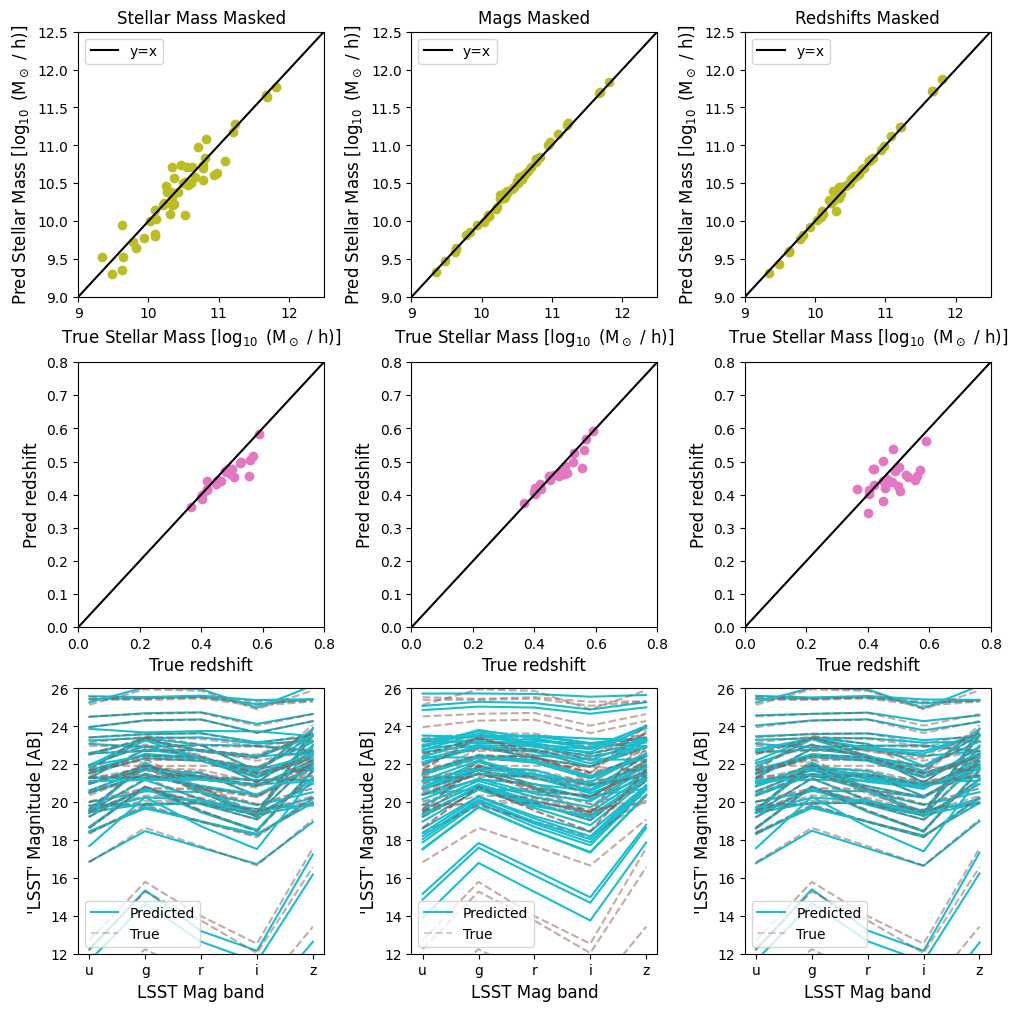

In [16]:
# columns:
# 0 : stellar mask
# 1 : magnitude mask
# 2 : redshift mask
colors = ["tab:olive", "tab:pink", "tab:cyan"]
titles = ["Stellar Mass Masked", "Mags Masked", "Redshifts Masked"]
xlabels = [r"True Stellar Mass [$\log_{10}$ (M$_\odot$ / h)]", "True redshift", "LSST Mag band"]
ylabels = [r"Pred Stellar Mass [$\log_{10}$ (M$_\odot$ / h)]", "Pred redshift", "'LSST' Magnitude [AB]"]
props = ['stellar_mass', 'redshift', 'mag_{band}_lsst']
lims = [[9, 12.5], [0,0.8], [12,26]]
fsize=12
fig, axs = plt.subplots(3, 3, figsize=(10,10), constrained_layout=True)
for row in range(len(axs)):
    title = None
    yxlabel = False
    xlabel = xlabels[row]
    ylabel = ylabels[row]
    for col in range(len(axs[0])):
        color = colors[col]
        ax = axs[row][col]
        if row==0:
            yxlabel = True
            title = titles[col]
        
        x = true_table[props[row]][col]
        y = predicted_table[props[row]][col]
        if row==2:
            xax = [1,2,3,4,5]
            ax.plot(xax, y[0][:-1], label = "Predicted", color = colors[row])
            ax.plot(xax, x[0][:-1], label = "True", color = "tab:brown", linestyle="dashed", alpha=0.3)
            for i, dat in enumerate(y[1:]):
                ax.plot(xax, dat[:-1], color = colors[row])
                ax.plot(xax, x[i][:-1], color = "tab:brown", linestyle="dashed", alpha=0.5)
            ax.legend()
            ax.set_ylabel(ylabel, fontsize=fsize)
            ax.set_xlabel(xlabel, fontsize=fsize)
            ax.set_xticklabels(['','u','g','r','i','z'])
            ax.set_ylim(lims[row][0], lims[row][1])
        else:
            plotAxScalarYX(x, y, ax, colors[row], xlabels[row], ylabels[row], lims[row], yxlabel, title=title, fsize=fsize)


fig.savefig(f'./outputs/gridScalarScatter_{num_umap}.pdf')


In [17]:
start = time()
with h5py.File(umap_dir, "r") as f:
    print(f"{f.keys()=}")
    print(f"{[[key, f[key].shape] for key in f.keys()]}")
    features = f["features"][:]  # shape: (N, D)
    scalars = [f[scalar][:] for scalar in scalar_keys]
    scalars = np.hstack(scalars)
    mag_band_lsst = f['mag_{band}_lsst'][:]

print(f"loaded umap_dir after {time()-start:.3f} sec")

f.keys()=<KeysViewHDF5 ['features', 'halo_mass', 'mag_{band}_lsst', 'redshift', 'stellar_mass']>
[['features', (750, 768)], ['halo_mass', (150, 1)], ['mag_{band}_lsst', (150, 6)], ['redshift', (150, 1)], ['stellar_mass', (150, 1)]]
loaded umap_dir after 0.005 sec


In [18]:
umap_model = umap.UMAP(n_components=2, random_state=42, verbose=1)
features_umap = umap_model.fit_transform(features)

UMAP(n_jobs=1, random_state=42, verbose=1)
Fri Dec 19 00:07:02 2025 Construct fuzzy simplicial set


/Users/snigdaa/Research/devenv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Fri Dec 19 00:07:02 2025 Finding Nearest Neighbors
Fri Dec 19 00:07:03 2025 Finished Nearest Neighbor Search
Fri Dec 19 00:07:04 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Dec 19 00:07:04 2025 Finished embedding


In [19]:
features_per_row = len(model.modalscalars) * scalars.shape[0] / len(combinations)

In [20]:
rgbs = []
features_umap_sub = {i: [] for i in range(len(combinations))}
rgbs_sub = {i: [] for i in range(len(combinations))}

marker = ['^', 'v', '>', '<', 'o', 's', 'D']
def softplus(x):
    return np.log(1 + np.exp(x))
def sigmoid(x, k=1):
    y = 1/(1+np.exp(-x/k))
    return y

for i, data in enumerate(tqdm(features_umap)):
    row = i // features_per_row
    rgb = scalars[i // len(model.modalscalars)]
    rgb = sigmoid(rgb)

    features_umap_sub[row].append(data)
    rgbs_sub[row].append(rgb)

100%|██████████| 750/750 [00:00<00:00, 370042.11it/s]


In [21]:
import math

def closest_factors(x):
    y = int(math.isqrt(x))
    while y > 0:
        if x % y == 0:
            z = x // y
            return y, z
        y -= 1

num_row, num_col = 1, len(combinations) 

print(f"{num_row=}; {num_col=}")

num_row=1; num_col=3


In [22]:
import alphashape
from descartes import PolygonPatch
from scipy.spatial import ConvexHull

def filter_percentile(points, low=5, high=95):
    x_min, x_max = np.percentile(points[:,0], [low, high])
    y_min, y_max = np.percentile(points[:,1], [low, high])
    mask = (points[:,0] >= x_min) & (points[:,0] <= x_max) & (points[:,1] >= y_min) & (points[:,1] <= y_max)
    return points[mask]

def draw_convex_hull(ax, points, color='black'):
    if len(points) < 3:
        return  # ConvexHull 至少需要 3 个点
        
    points = filter_percentile(points, .1, 99.9)

    hull = ConvexHull(points)
    for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], color=color, lw=1, alpha=0.7, linestyle='--')

In [23]:
comb_map = {
    'redshift': 'z',
    'halo_mass': r'M_{\mathrm{halo}}',
    'stellar_mass': r'M_\mathrm{stellar}',
    'SFH': r'\mathrm{SFH}',
    'SED': r'\mathrm{SED}',
    'mag_{band}_lsst': r'\mathrm{LSST}',
    'mag_{band}_spherex': r'\mathrm{SPHEREx}',
}

ylabels = {
    'SFH': r'\log_{10}(\frac{\mathrm{d}M_*}{\mathrm{d}t}\ \mathrm{[\frac{M_\odot}{yr}]})',
    'SED': r'\log_{10}(F_\lambda[Jy])',
    'mag_{band}_lsst': r'\mathrm{Magnitude (AB)}',
    'mag_{band}_spherex': r'\mathrm{Magnitude (AB)}', 
    'redshift': r'z', 
    'halo_mass': r"\log_{10}(M_{\rm halo}[\frac{\mathrm{M}_\odot}{\rm h}])", 
    'stellar_mass': r"\log_{10}(M_*[\frac{\mathrm{M}_\odot}{\rm h}])",
}

title_map = {
    'SFH': r'Star Formation History',
    'SED': r'Spectral Energy Distribution',
    'mag_{band}_lsst': 'LSST Photometry',
    'mag_{band}_spherex': 'SPHEREx Photometry', 
    # 'scalars': 'Scalars',
    'redshift': 'Redshift',
    'halo_mass': 'Halo Mass',
    'stellar_mass': 'Stellar Mass',
}

def comb2latex(comb):
    latexed = []
    given = torch.tensor([mp != 1 for mp in comb])
    # print(f"🌟 {comb=}; {given=}")
    given = np.array(model.modalities)[given]
    for mod in given:
        latexed.append(comb_map[mod])
    # print(f"{given=}; {latexed=}")
    return '+'.join(latexed)

100%|██████████| 3/3 [00:00<00:00, 107.11it/s]


comb=(1, 1, (4, 0), 1, 0, 1, 1): data.shape=(250, 2)
comb=(1, 1, 1, 1, 0, 1, 0): data.shape=(250, 2)
comb=(1, 1, 0, 1, 1, 1, 0): data.shape=(250, 2)


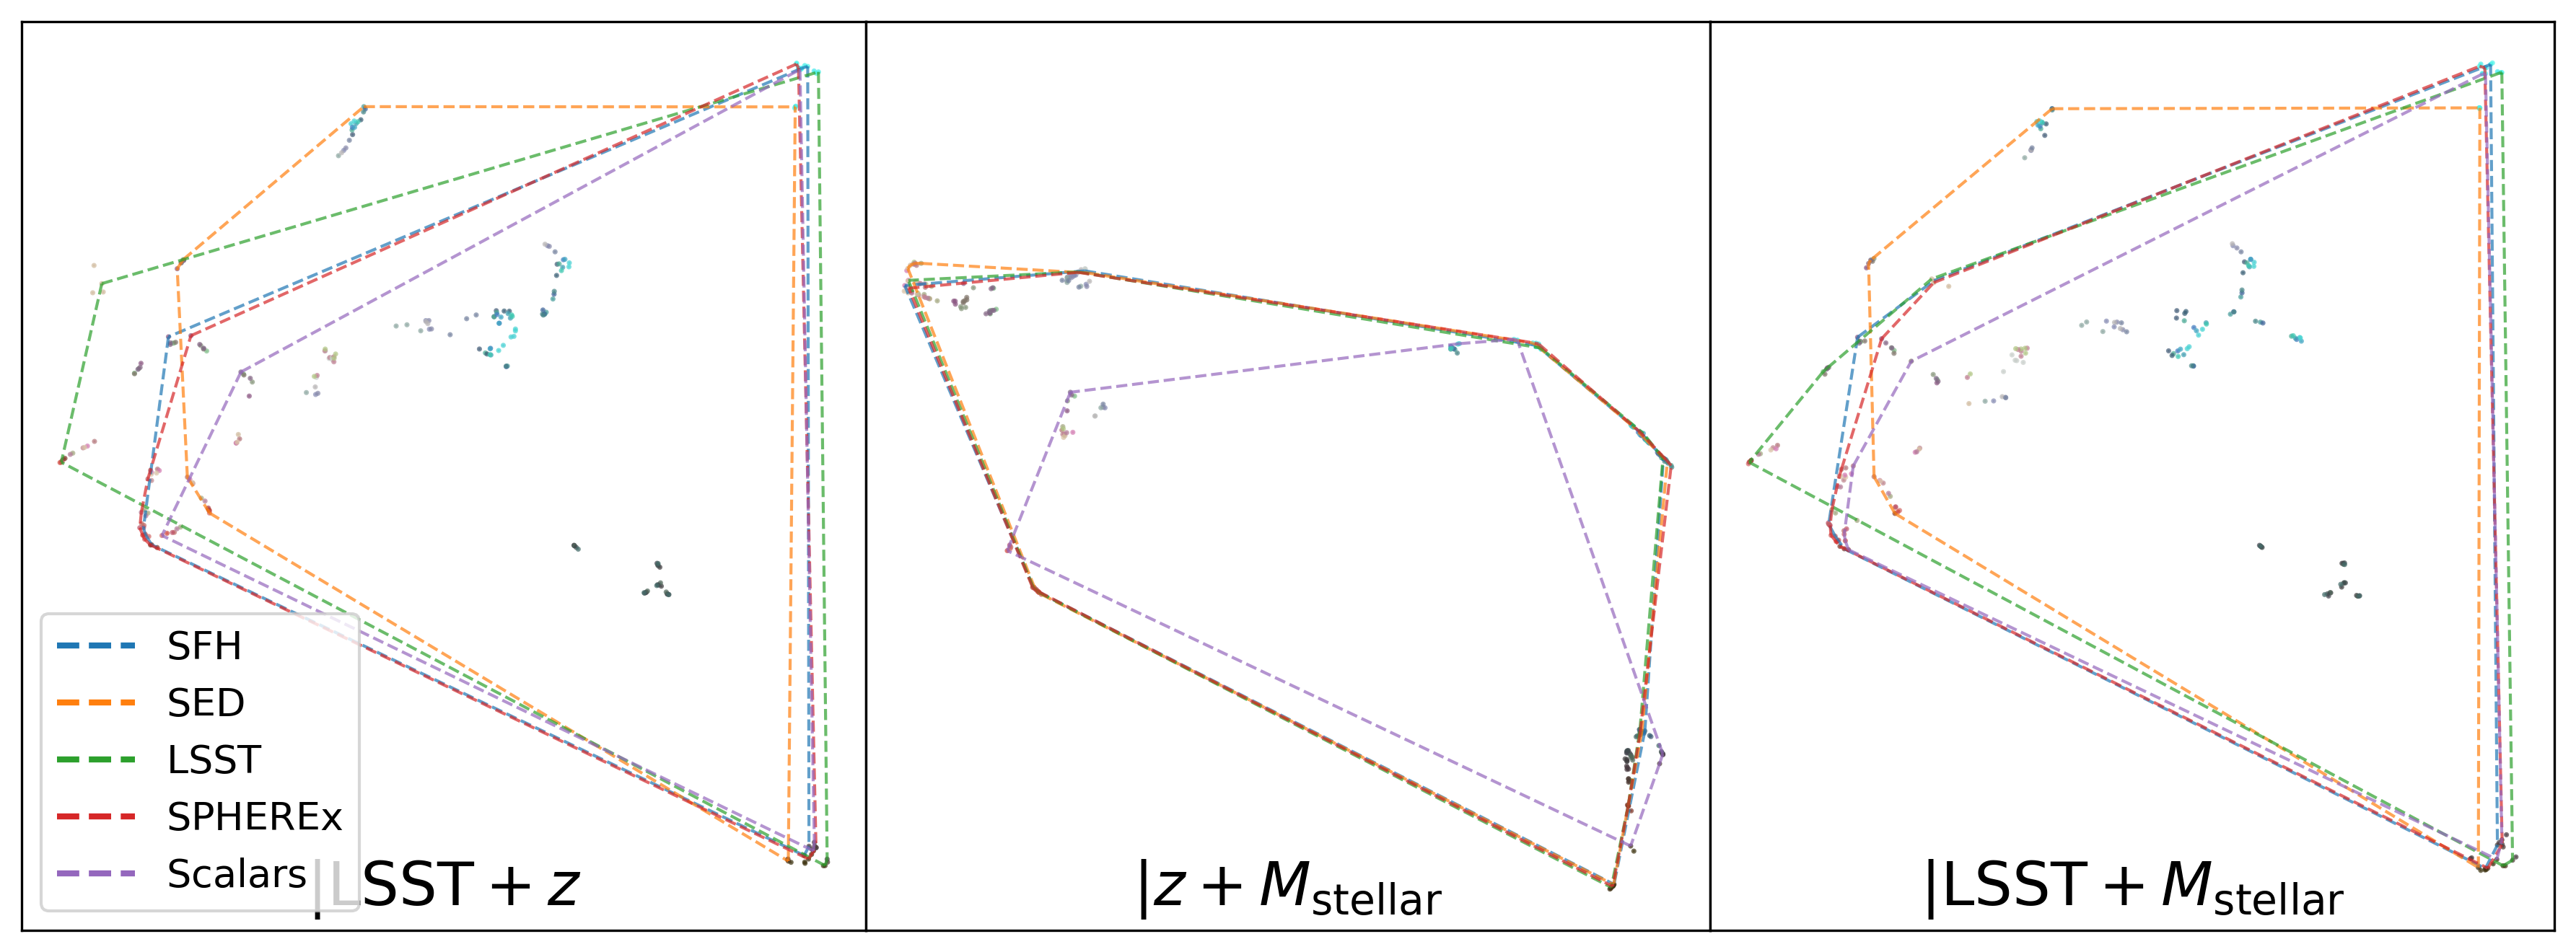

In [24]:
# === 3. Plot side-by-side ===
fig, axs = plt.subplots(num_row, num_col, figsize=(4*num_col, 4.5*num_row), sharex='col', sharey='row', dpi=300)
axs = axs.flatten() if type(axs) is np.ndarray else [axs]

for row, comb in enumerate(tqdm(combinations)):
    data = np.array(features_umap_sub[row])
    print(f"{comb=}: {data.shape=}")
    for i, modality in enumerate(model.modalscalars):
        if len(data) != 0:
            axs[row].scatter(
                data[i::len(model.modalscalars),0], 
                data[i::len(model.modalscalars),1], 
                # label=f"${comb_map.get(model.modalscalars[i], r'\mathrm{Scalars}')}$" if row==0 else None,
                s=.5, alpha=0.7, rasterized=True,
                c=rgbs_sub[row][i::len(model.modalscalars)])#, marker=marker[i])#, cmap='coolwarm')#, edgecolors='k')

            draw_convex_hull(axs[row], data[i::len(model.modalscalars)], color=f"C{i}")

    label = f"|${comb2latex(comb)}$"
        
    axs[row].text(0.5, 0.01, label, fontsize=20, color='k', ha='center', va='bottom', transform=axs[row].transAxes)
    axs[row].set_xticks([])
    axs[row].set_yticks([])

custom_handles = []
custom_labels = []

for i, m in enumerate(model.modalscalars):
    line_handle = Line2D([0], [0], color=f"C{i}", lw=2, linestyle='--')

    custom_handles.append((line_handle))
    custom_labels.append(f"${comb_map.get(m, r'\mathrm{Scalars}')}$")


axs[0].legend(custom_handles, custom_labels,
              handler_map={tuple: HandlerTuple(ndivide=None)},
              fontsize=13, loc="best")


plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig(f"outputs/uMap_{len(masking_prob)}.pdf", dpi=600)
plt.show()